### Import packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Raw file

In [15]:
# File path
data_route = "../../data/raw_data.csv"
data = pd.read_csv(data_route)
data['Date'] = pd.to_datetime(data['Date'])

In [16]:
# Check the data
data.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2023-04-03 13:30:00+00:00,408.850006,411.309998,408.820007,411.190002,14278892.0,SPY
1,2023-04-03 14:30:00+00:00,411.200012,411.369995,408.440002,409.040009,10506955.0,SPY
2,2023-04-03 15:30:00+00:00,409.059998,409.890015,408.970001,409.640106,7643987.0,SPY
3,2023-04-03 16:30:00+00:00,409.644989,409.779999,408.950012,409.209991,5003256.0,SPY
4,2023-04-03 17:30:00+00:00,409.220001,409.679993,408.899994,409.609985,6087517.0,SPY


In [23]:

daily_data = (
    data.groupby(['Ticker', pd.Grouper(key='Date', freq='D')])  # Group by Ticker and Date (daily frequency)
    .agg({
        'Open': 'first',   # First price of the day
        'High': 'max',     # Highest price of the day
        'Low': 'min',      # Lowest price of the day
        'Close': 'last',   # Last price of the day
        'Volume': 'sum',   # Total volume of the day
        'Ticker': 'size'   # Count the number of hourly data points (transactions)
    })
    .rename(columns={'Ticker': 'Daily_Transactions'})  # Rename the count column
    .reset_index()
)

# Calculate the total number of days of data for each ticker
days_per_ticker = daily_data.groupby('Ticker')['Date'].nunique()

# Display the results
print("Number of days of data for each ticker:")
print(days_per_ticker)

print("\nDaily data with number of transactions:")
print(daily_data.head(10))

# Average daily number of transactions
avg_daily_transactions = daily_data.groupby('Ticker')['Daily_Transactions'].mean()
print("\nAverage daily number of transactions for each ticker:")
print(avg_daily_transactions)


Number of days of data for each ticker:
Ticker
BTC-USD     697
DOGE-USD    697
ETH-USD     697
SOL-USD     697
SPY         477
XRP-USD     697
Name: Date, dtype: int64

Daily data with number of transactions:
    Ticker                      Date          Open          High  \
0  BTC-USD 2023-04-01 00:00:00+00:00  28473.332031  28802.457031   
1  BTC-USD 2023-04-02 00:00:00+00:00  28462.845703  28518.958984   
2  BTC-USD 2023-04-03 00:00:00+00:00  28183.080078  28475.623047   
3  BTC-USD 2023-04-04 00:00:00+00:00  27795.273438  28433.742188   
4  BTC-USD 2023-04-05 00:00:00+00:00  28169.726562  28739.238281   
5  BTC-USD 2023-04-06 00:00:00+00:00  28175.226562  28178.384766   
6  BTC-USD 2023-04-07 00:00:00+00:00  28038.966797  28111.593750   
7  BTC-USD 2023-04-08 00:00:00+00:00  27923.943359  28159.863281   
8  BTC-USD 2023-04-09 00:00:00+00:00  27952.367188  28532.830078   
9  BTC-USD 2023-04-10 00:00:00+00:00  28336.027344  29771.464844   

            Low         Close        Volum

This finding makes sense, as SPY does not operate over the weekends.

## Features engineering
Now we have the calculate the key metrics, similar to how we did it in the group component

In [ ]:
# Calculate daily returns, cumulative returns, etc.
data['hourly_return'] = data.groupby('Ticker')['Close'].pct_change()
data['cumulative_return'] = (1 + data['hourly_return']).groupby(data['Ticker']).cumprod()
data['hourly_log_return'] = data.groupby('Ticker')['Close'].transform(lambda x: x.pct_change())

# Daily realised variance: Sum the hourly log returns squared.
data['daily_realised_variance'] = data.groupby(['Ticker', pd.Grouper(key='Date', freq='D')])['hourly_log_return'].transform(lambda x: np.sum(x**2))

# Group the data to make it daily now
daily_data = (
    data.groupby(['Ticker', pd.Grouper(key='Date', freq='D')])  # Group by Ticker and Date (daily frequency)
    .agg({
        'Open': 'first',   # First price of the day
        'High': 'max',     # Highest price of the day
        'Low': 'min',      # Lowest price of the day
        'Close': 'last',   # Last price of the day
        'Volume': 'sum',   # Total volume of the day
        'daily_realised_variance': 'last'
    })
    .reset_index()
)


## Feature engineering
Now we need to ln weight the daily realised variance, and also calculate the seven day and monthly realised variance

In [36]:
### Calculate the weekly and monthly realised variance by doing sum of daily realised variance
# Calculate lagged moving averages
daily_data['7_day_moving_avg_rv'] = (
    daily_data.groupby('Ticker')['daily_realised_variance']
    .rolling(window=7).mean()
    .reset_index(level=0, drop=True)
)

daily_data['30_day_moving_avg_rv'] = (
    daily_data.groupby('Ticker')['daily_realised_variance']
    .rolling(window=30).mean()
    .reset_index(level=0, drop=True)
)

# Create lagged features for forecasting
daily_data['lagged_7_day_ma'] = daily_data.groupby('Ticker')['7_day_moving_avg_rv'].shift(1)  # Lag by 1 day
daily_data['lagged_30_day_ma'] = daily_data.groupby('Ticker')['30_day_moving_avg_rv'].shift(1)  # Lag by 1 day

# Drop rows with NaN values caused by lagging
daily_data.dropna(subset=['lagged_7_day_ma', 'lagged_30_day_ma'], inplace=True)


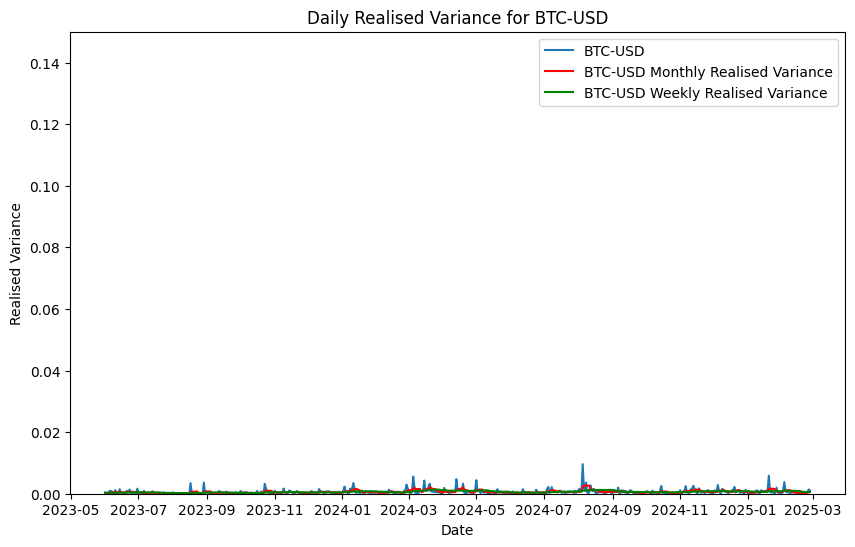

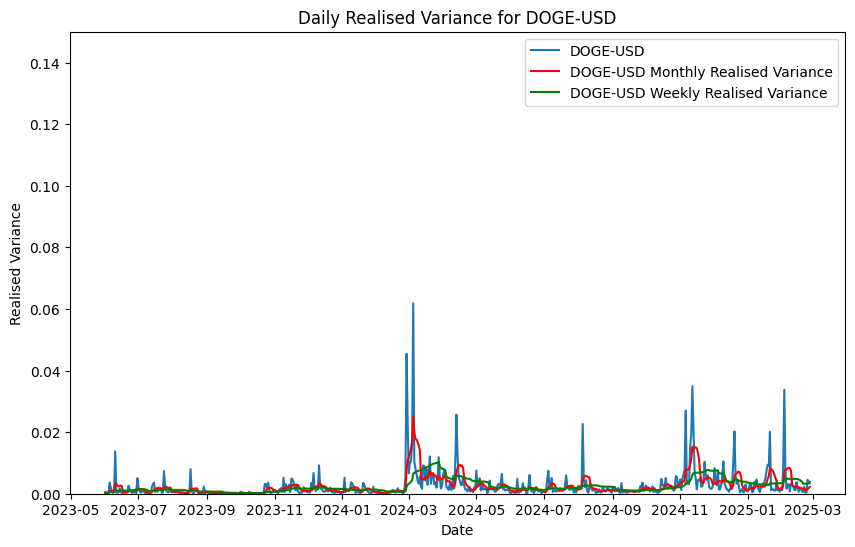

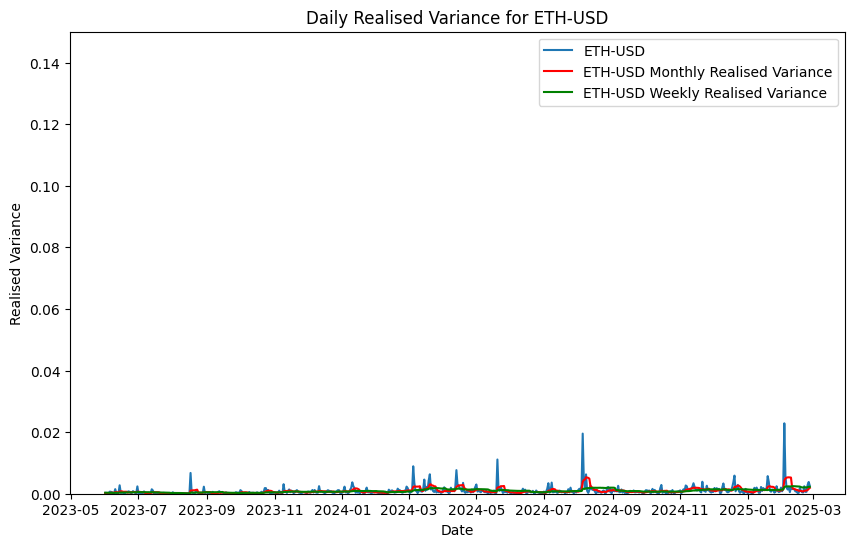

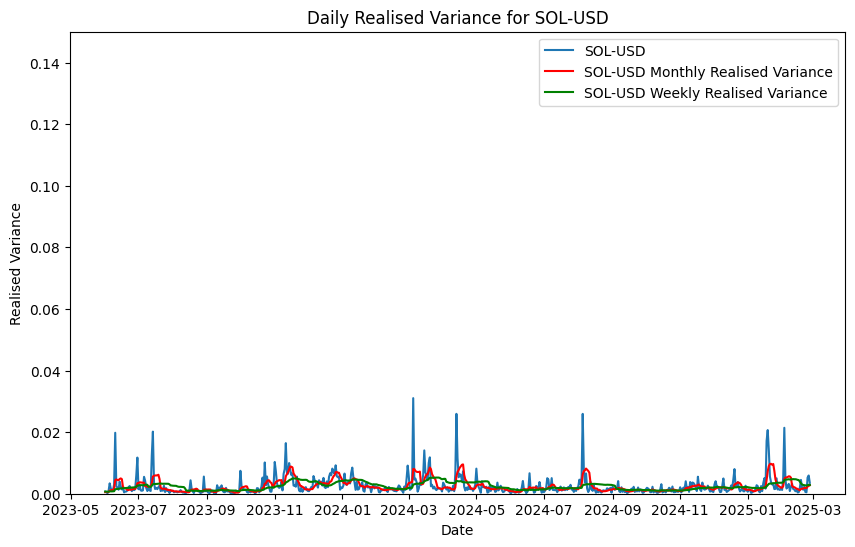

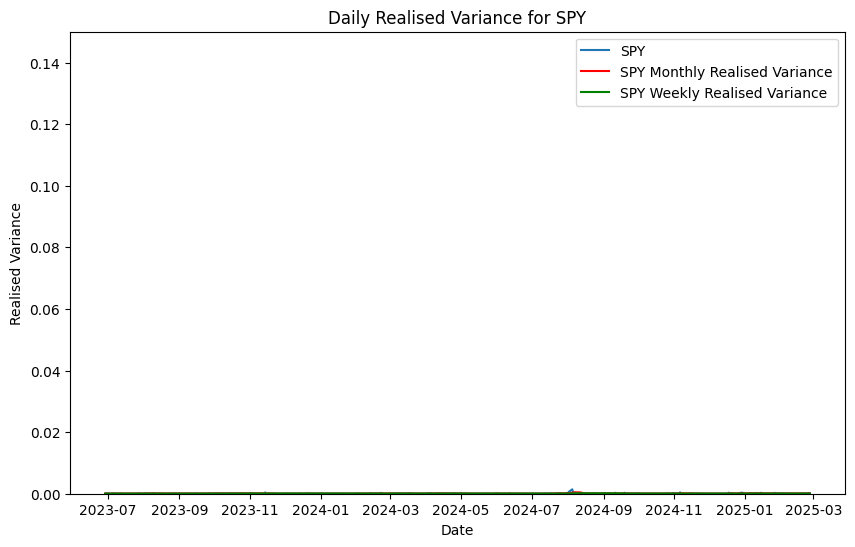

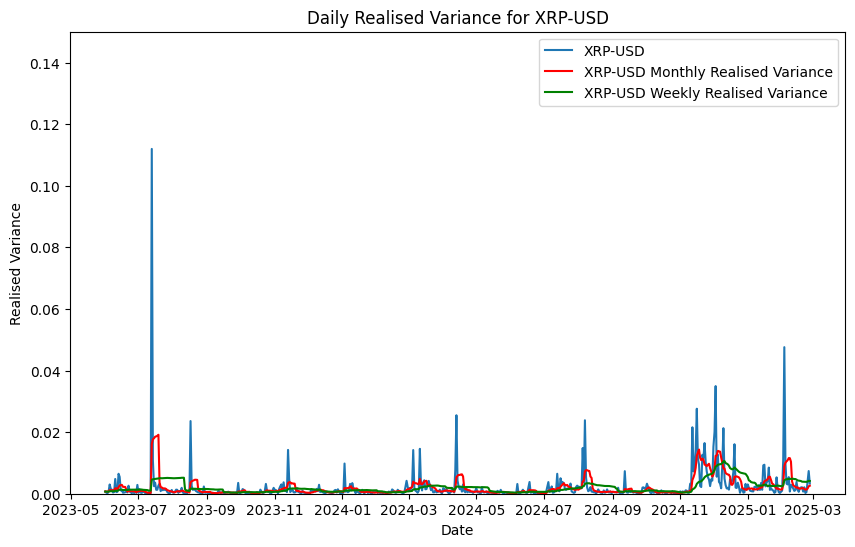

In [37]:
### Plot the daily realised variance
# Plot the daily realised variance for each ticker on different plots
for ticker, ticker_data in daily_data.groupby('Ticker'):
    plt.figure(figsize=(10, 6))
    plt.plot(ticker_data['Date'], ticker_data['daily_realised_variance'], label=ticker)
    plt.plot(ticker_data['Date'], ticker_data['7_day_moving_avg_rv'], label=f'{ticker} Monthly Realised Variance', color='red')
    plt.plot(ticker_data['Date'], ticker_data['30_day_moving_avg_rv'], label=f'{ticker} Weekly Realised Variance', color='green')
    plt.title(f'Daily Realised Variance for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Realised Variance')
    plt.ylim(0, 0.15)
    plt.legend()
    plt.show()    
    